**You need to submit 2 things:**
- On **Crowdmark**, answers to each question:
 - for questions without code, as usual (you can take a screenshot of your answer in the colab cell or write it down on a separate medium)
 - for questions with code, take a screenshot of the code and upload it to Crowdmark 
- On **Quercus**, submit a ipynb file with your entire code

# **Sentiment Analysis Using Gated-Recurrent Neural Networks**

In this assignment, we will use the IMDB dataset that contains the text of 50,000 movie reviews from the Internet Movie Database (IMDB) website. The label of each movie review is either positive or negative. An example of the input-output pair in this dataset is

"*I happen to run into this movie one night so I decided to watch it ! I was very pleased with the movie ... I thought it was a wonderful plot . It 's a great feeling knowing a deceased one has come back and you get that second chance to say what you want to say ! And this wife stayed devoted for 23 years ! ! ! I thought it was a great movie ! !*"

where its label, as you might expect, is 
"*positive*".

**In this assignment, we want to design a classifier that takes as input a review and outputs whether it is a positive or negative review about a movie.**

In the next two cells, we import some modules and also fix some constants for our implementation. 

In [1]:
import csv
from typing import Callable, Tuple

import jax.numpy as jn
import matplotlib.pyplot as plt
import numpy as np
from jax import lax
from keras_preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from tqdm import trange
from sklearn.model_selection import train_test_split
%pip --quiet install objax
import objax
from objax.typing import JaxArray


objax.random.DEFAULT_GENERATOR.seed(42)
np.random.seed(42)

     |████████████████████████████████| 57 kB 1.6 MB/s 


In [ ]:
!gdown --id 11r58MB8wRBO1o1gEC-zxiADZIuwMnhf7

/usr/local/lib/python3.8/dist-packages/gdown/cli.py:127: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=11r58MB8wRBO1o1gEC-zxiADZIuwMnhf7
To: /content/IMDB Dataset.csv
100% 66.2M/66.2M [00:00<00:00, 237MB/s]


In [ ]:
max_vocab = 2000  # this parameter is for the maximum number of words in the "dictionary"
max_len = 200  # maximum length of each review
embedding_size = 30  # size of embedding
num_hidden_units_GRU = 30  # GRU cells in the RNN layer
num_hidden_units = 60  # hidden unit of dense network after GRU

vocab_size = max_vocab
filename = 'IMDB Dataset.csv'

# How to find a representation of sentences?
In order to put the words into the machine learning algorithm the text data should be converted into a vector representation. The first approach that comes to mind is *one hot encoding*.
 # One Hot Encoding
Assume that we count the number of english words in the Merriam-Webster dictionary, and it turns out that the total number of words is $N$. Then, a possible way to represent the words is to use binary vectors of size $N$. Each integer value is represented as a binary vector that is all zero values except the index of the integer, which is marked with a $1$.
As an example let's say all the words in the dictionary consists of $\{$apple, orange, Milan,Rome$\}$. For this example, the one hot encoding is given by:
 
apple = $[1,0,0,0]$ \\
orange = $[0,1,0,0]$ \\
Milan = $[0,0,1,0]$  \\
Rome = $[0,0,0,1]$
 
We can also represent each word by an integer: for instance in the above-mentioned example, the mapping is apple $\rightarrow$ 1, orange $\rightarrow$ 2, Milan $\rightarrow$ 3,  Rome $\rightarrow$ 4.
 



When we are working with a dataset, a practical approach for one-hot encoding of the data is as follows:
 
1.  First, we can create a dictionary which shows each word along with its frequency in the dataset. For example, if the sentence is "Put the books on the table." , we need to create a dictionary such that word_index["Put"] = 1; word_index["the"] = 2; word_index["books"] = 1; word_index["on"] = 1; word_index["table"] = 1.
2.  Second, based on the maximum size of the vocabulary we want, we can sort the words based on their frequency and only pick the most frequent words of this maximum size of the vocabulary, and this creates our dictionary. So lower integer means more frequent word (often the first few are stop words because they appear a lot)
 
3. Then, we can assign an integer to each word in the dictionary, and represent each sentence as a sequence of integers.
 
 
The following function performs the above-mentioned steps for our IMDB dataset.



In [ ]:
def data_processing(filename, max_vocab, max_len):
  # filename: the name of the .csv file
  # max_vocab: The maximum number of words
  # max_len: 
  messages = []  # a list contains the reviews
  labels = []  # a list contains the labels
  with open(filename, 'r') as file:
      reader = csv.reader(file)
      firstline = True
      for row in reader:
        if firstline:
            firstline = False
            continue
        else:
            messages.append(row[0])
            labels.append(int(row[1]=='positive'))

  tokenizer = Tokenizer(num_words=max_vocab)
  tokenizer.fit_on_texts(messages)
  messages_seq = tokenizer.texts_to_sequences(messages)
  data = pad_sequences(messages_seq, maxlen=max_len)  
  train_size = 0.8
  messages_train, messages_valid_test, labels_train, labels_valid_test  = train_test_split(data, labels, train_size=train_size)
  messages_valid, messages_test, labels_valid, labels_test  = train_test_split(messages_valid_test, labels_valid_test, train_size=0.5)
  return np.array(messages_train), np.array(labels_train), np.array(messages_valid), np.array(labels_valid), np.array(messages_test), np.array(labels_test)

For the data_processing function, we used Tokenizer which is a class in keras.preprocessing.text. The following questions are about the different methods in this class. \\



**Question 1** [1 points]: In your own words, explain what does "fit_on_texts" do? \\

"fit_on_texts" uses a list of texts to refresh the internal vocabulary. Based on the frequency of each word in the text, it generates a vocabulary word index for the given list of texts. We may then express each phrase as a sequence of integers by giving each word in the dictionary an integer. The list's entries are all taken to be tokens.

**Question 2** [1 points]: In your own words, explain what does "texts_to_sequences" do? \\

Each text/string in the "messages" list is converted to an integer sequence by the function "texts_to_sequences", which then produces a new list. A list of text strings are used as its input, while a list of sequences is used as its output. To accomplish this, it substitutes each word with the relevant integer word index, as defined in the tokenizer.word index variable. "texts_to_sequences" is typically invoked after "fit_on_texts".

**Question 3** [1 points]: In your own words, explain what does "pad_sequences" do, and why do we need it? \\

"pad_sequences" pads 0s to sequences until they are max_len long for phrases that are less than max_len words long. Sentences that are longer than max_len words are trimmed to be no longer than max_len words. We utilise this function because a supplied text may have sentences of varying lengths (eg, "My name is Shadman. It is really hot today and I am sweating buckets.") We may use the same word index dictionary for both phrases thanks to padding. Due to padding, it ensures that because all of the inputs have the same shape, we can apply the same neural network architecture for all of them.

In the next cell, we encode the data set using one-hot encoding, and split the dataset into the training set, validation set, and the test test.

In [ ]:
messages_train, labels_train, messages_valid, labels_valid, messages_test, labels_test = data_processing(filename, max_vocab, max_len)

**Question 4** [1 points]: Print one of the input in the training set and explain your observation? Does it match with what you expected?

In [ ]:
print("messages_train[1]:") 
print(messages_train[1])
print("The length of messages_train[1] is: ", len(messages_train[1]))

messages_train[1]:
[  10   37   97  195 1625    2  721   18   67   61   26   14    3 1625
  602   30    3  202    7    7    1  448    6  330  507   96  249    5
   76    1  309    5  423    1  111  184    5   26   32 1386   15  712
 1370   36   27  129    5  157  313    6  335    2 1514   38   29   24
  685  215  618   14 1370    6  700  248   71  647    3  214    9   22
  203   41    4    1   64  252  129    6 1309  718    1   12   80   20
    1  268    6  595   14  526   14  252  129    6 1706    8 1317  138
   14  439    1   31    1  418  108   23  152   84   22   67   16    1
  102    2 1560    2    1  872    1  108  653   53    8    6   21  188
  411    1  558   12   28    6   53    8    3 1827  602    5    3  423
   36    1  309    7    7   43 1370   66   21  253  138   32 1176  108
   35  110   62   16    1   79  102    8    1   17    2  645    6 1099
  556   15  264    5  925    2    1  202  134 1190   34  718    2   29
    1  616  463  225   96 1077   11   17   98   25   75 17

This matches with what I expected. I see the length of "messages_train[1]" being 200, fulfilling the constraint that all inputs must have length 200. Furthermore, I see a sequence of integers which represent the converted words to numbers. I see a lot of smaller numbers such as 1, 2, and 3, which also makes sense as these are probably more common words in the the vocabulary and appear more often than unorthodox words.

# Embedding Layer



Imagine that we have 80,000 unique words in a text classification problem and we select to preprocess the text as explained above. For instance, a sentence "i love you" or ['i', 'love', 'you'] can be shown as a matrix of size (3 , 80000) where its elements is all zeros except from 3 elements that correspond to those words. In the case that we want to extract the feature using recurrent neural netowk, the input size should be the size of $80,000$ in which only three entries are non-zero!

Instead, we can use the observation that since our goal is to extract feature from a sentence, we might be able to construct a mapping so that the words whose meanings are similar map to the same vector. One possible approach to do this is to perform this maaping using a simple matrix multiplication that transforms words into their corresponding word embeddings or turns positive integers (indexes) into dense vectors of fixed size, where the size of embedding $\ll$ size of the vocabualry. 

Please watch this short video to gain better understanding of the embedding layer:


https://www.coursera.org/lecture/nlp-sequence-models/learning-word-embeddings-APM5s


Since Objax does not have embedding layer module in it, we need to write our own module. One implementaiton of the embedding layer is as follows. 

In [ ]:
class Embed(objax.Module):
    def __init__(self, size: int, latent: int, init: Callable = objax.nn.init.xavier_truncated_normal):
        self.w = objax.TrainVar(init((size, latent)))

    def __call__(self, x: JaxArray) -> JaxArray:
        return self.w.value[x]

**Question 5: [1 points]**  Briefly explain how `__init__` and `__call__` functions work when the input is a sentence?

When using the "_init_" function, a size latent matrix is initialised, with size equal to the number of words in the vocabulary (2000) and latent to the embedding size (30). This is equivalent to a 2000*30 matrix.

"_call_" operates by transforming a word or sentence to its embedding. The self.w.value[x] line, which retrieves rows of w determined by elements in x, accomplishes this. We would merely pass the word's index from our vocabulary if we wanted to extract embedding for a single word. We pass in the sequence matching to the sentence if we want it to be embedded.

# Gated Recurrent Unit Cell
GRUs are a family of the recurrent neural networks used for processing of the sequential data. In this assignment, we want to use GRU for the sentiment analysis.

The forward pass of a Gated Recurrent Unit is defined by the following equations:




1.   $z_t = \text{sigmoid} (W_z x_t + U_z h_{t-1} + b_z)$
2.   $r_t = \text{sigmoid} (W_r x_t + U_r h_{t-1} + b_r)$
3.   $\hat{h}_t = \text{tanh} (W_h x_t + U_h (r_t \odot h_{t-1}) + b_h)$
4.   $h_t =  (1-z_t)\odot h_{t-1} + z_t \odot \hat{h}_t$

where
the operator ${\displaystyle \odot }$  denotes the Hadamard product, and 

*  $x_{t}$: input vector
*   $h_{t}$: output vector
* ${\hat {h}}_{t}$: candidate activation vector
* $z_{t}$: update gate vector
* $r_{t}$: reset gate vector
* $W_z$, $W_r$, $W_h$ , $U_z$, $U_r$, $U_h$, $b_z$ ,$b_r$, $b_h$ are parameter matrices and vectors.







The schematic of a GRU cell is show below (taken from Wikipedia). Here $\hat{y}_t$ is the same as $h_t$, and $\sigma$ is sigmoid function.

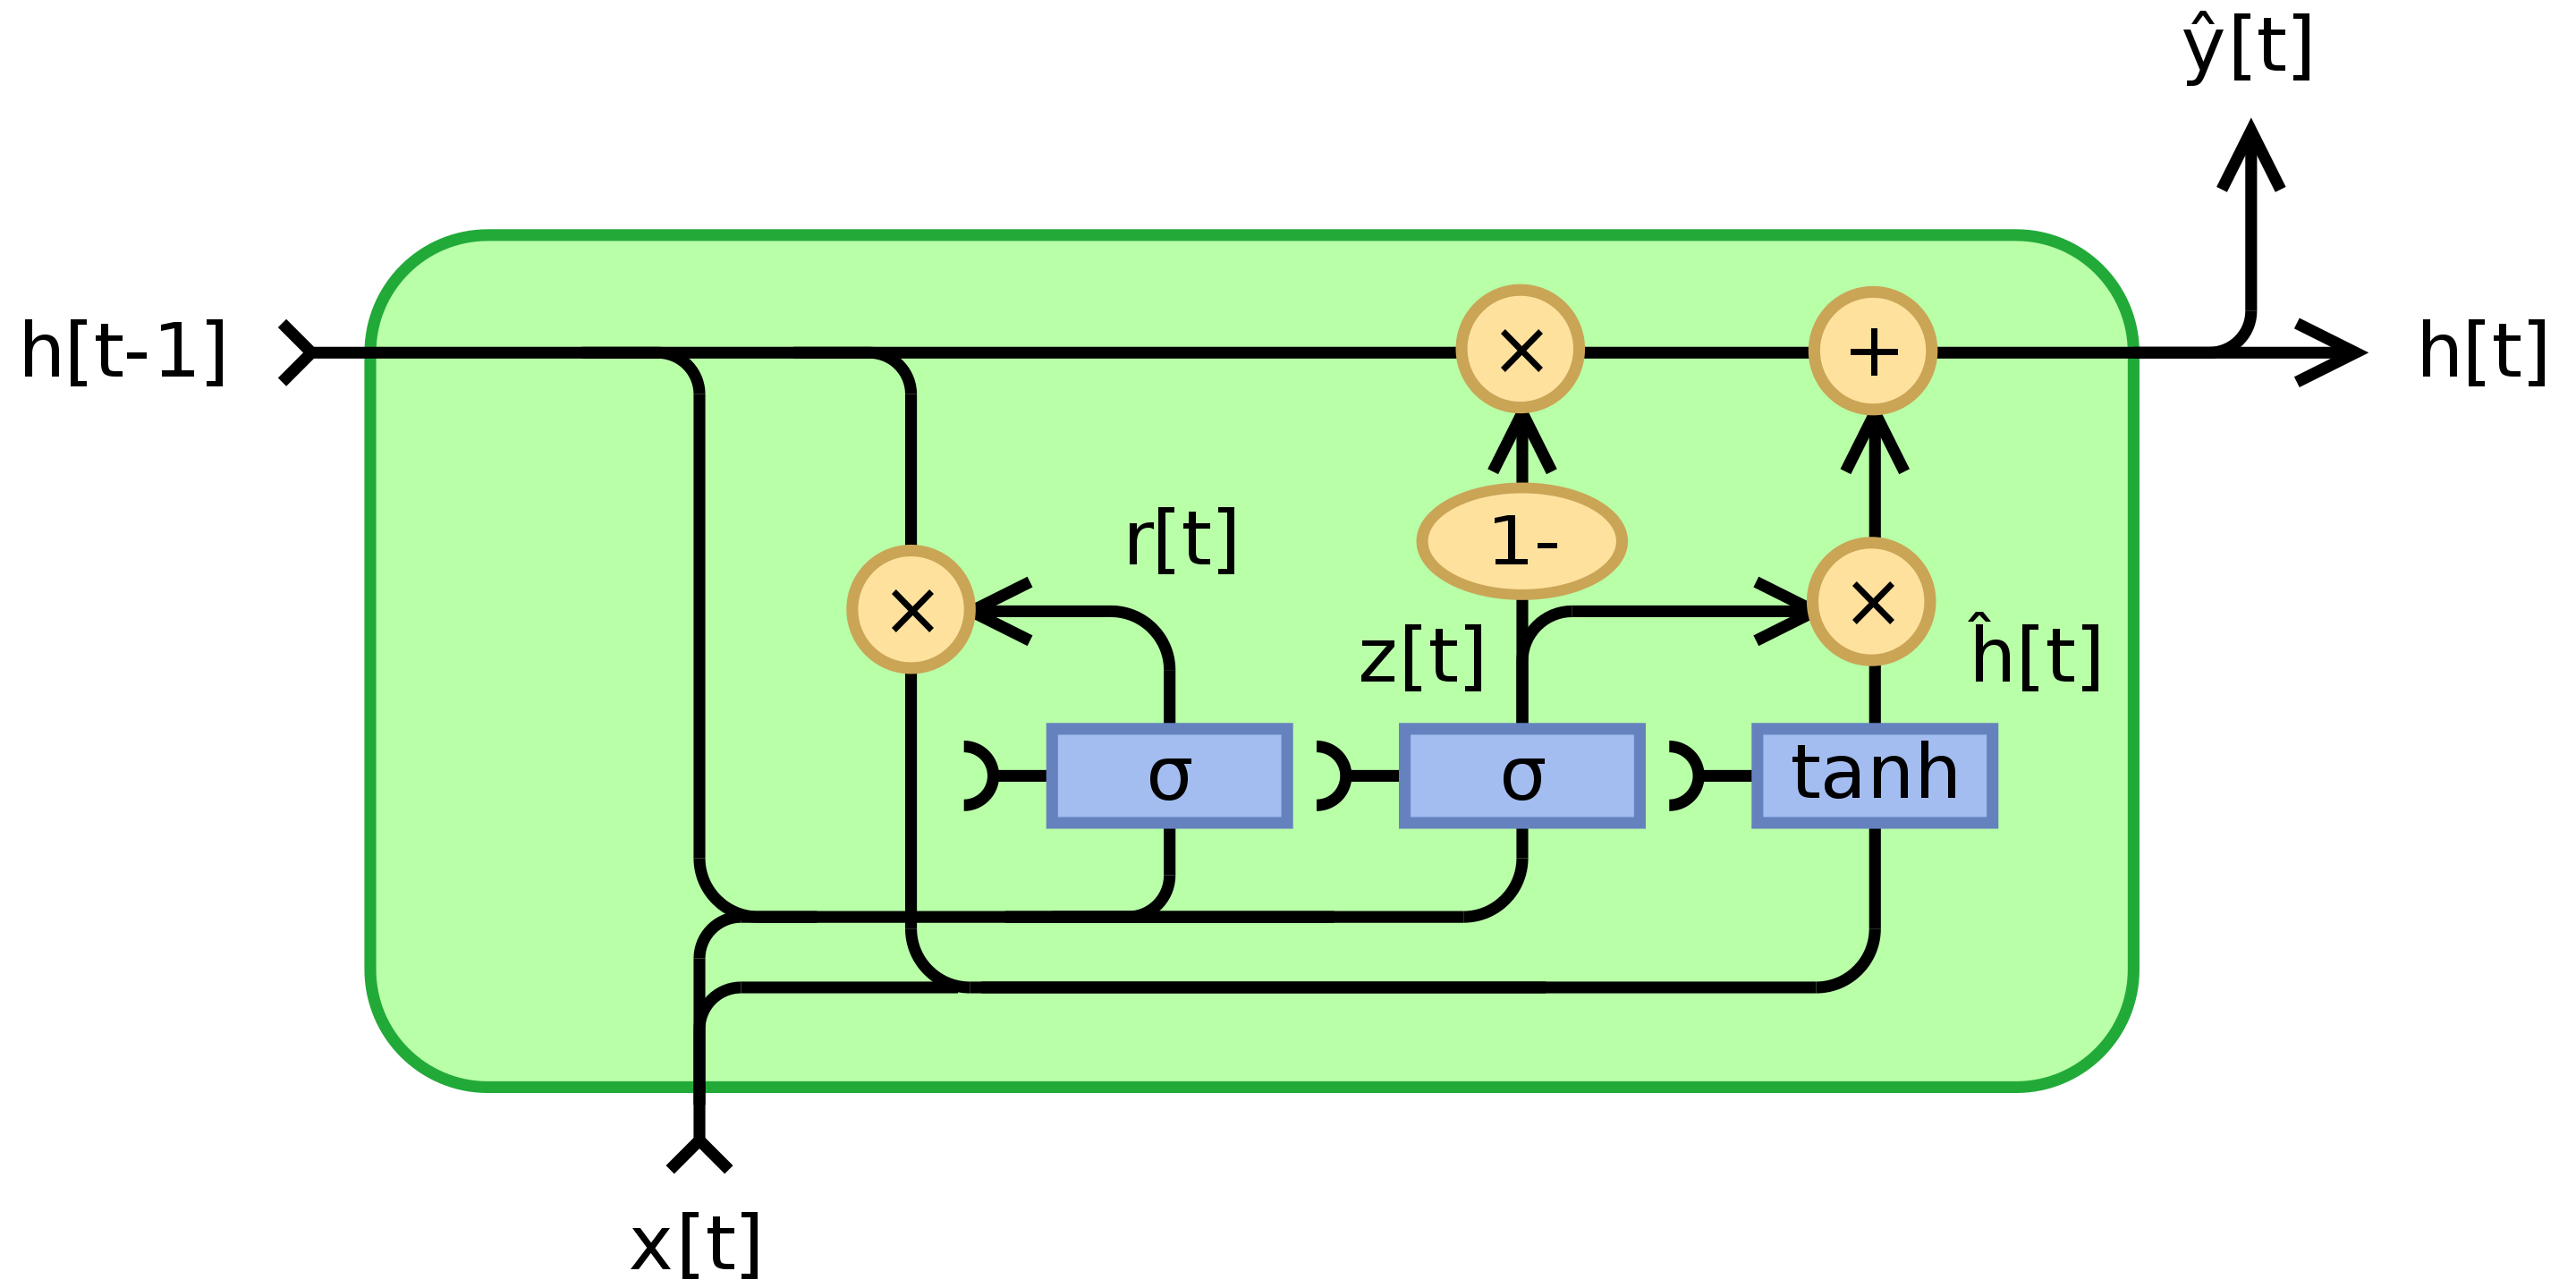

To learn more about GRU, please watch these short videos:

https://www.coursera.org/lecture/intro-to-deep-learning/modern-rnns-lstm-and-gru-WpduX

https://www.youtube.com/watch?v=pYRIOGTPRPU

Similar to the embedding layer, GRU module is not implemented in the Objax. The following is an implementation of the GRU cell in the Objax.

**Question 6[3 points]:** In the following implementation, complete the `__call__` function. 

In [ ]:
class GRU(objax.Module):
    def __init__(self, nin: int, nout: int,
                 init_w: Callable = objax.nn.init.xavier_truncated_normal,
                 init_b: Callable = objax.nn.init.truncated_normal):
        self.update_w = objax.TrainVar(init_w((nin, nout)))
        self.update_u = objax.TrainVar(init_w((nout, nout)))
        self.update_b = objax.TrainVar(init_b((nout,), stddev=0.01))
        self.reset_w = objax.TrainVar(init_w((nin, nout)))
        self.reset_u = objax.TrainVar(init_w((nout, nout)))
        self.reset_b = objax.TrainVar(init_b((nout,), stddev=0.01))
        self.output_w = objax.TrainVar(init_w((nin, nout)))
        self.output_u = objax.TrainVar(init_w((nout, nout)))
        self.output_b = objax.TrainVar(init_b((nout,), stddev=0.01))

    def __call__(self, x: JaxArray, initial_state: JaxArray) -> Tuple[JaxArray, JaxArray]:
        def scan_op(state: JaxArray, x: JaxArray) -> JaxArray:  # State must come first for lax.scan
            # fill this in
            update_gate = objax.functional.sigmoid(jn.matmul(x, self.update_w.value) + jn.matmul(state, self.update_u.value) + self.update_b.value) 

            # fill this in
            reset_gate = objax.functional.sigmoid(jn.matmul(x, self.reset_w.value) + jn.matmul(state, self.reset_u.value) + self.reset_b.value)
            
            # fill this in
            output_gate =  objax.functional.tanh(jn.matmul(x, self.output_w.value) + jn.matmul(jn.multiply(reset_gate, state), self.output_u.value) + self.output_b.value) 
            
            #return update_gate * state + (1 - update_gate) * output_gate, 0  # we don't use the output, return 0.
            return (1-update_gate) * state + (update_gate) * output_gate, 0   # we don't use the output, return 0.

        return lax.scan(scan_op, initial_state, x.transpose((1, 0, 2)))[0]

**Questions 7** (bonus)[5 points]: With an example, explain in detail what does lax.scan function do, and what it is useful for?

According to https://jax.readthedocs.io/en/latest/_autosummary/jax.lax.scan.html, the lax.scan function "scans a function over leading array axes while carrying along state." The way that lax.scan works is that: we begin with a initial state and n1, our first input. On the tuple (initial state, n1), we carry out an operation to obtain a new tuple (new state, out1). The new state is then utilised in the following iteration to move from (new state, n2) to (another new state, out2). It is obvious that each iteration's new state and output are entirely functions of the previous iteration's old state and current input. We continue until we go through all the inputs. 

The benefit of lax.scan is that it speeds up the compilation process for just-in-time compiled routines. More complex accelerated linear algebra computations can be performed since native Python for loops in jit functions are unrolled. Since each GRU cell accepts a state and an input word and provides an output and a new state, it makes sense to utilise lax.scan in our instance. We can still benefit from the running time improvement that lax.scan provides us even though the output for all but the last cell is meaningless to us.

Thus, lax.scan has many practical applications such as simulating compound interest and the stick breaking process in Bayesian non-parametric modelling.

References:

https://www.programcreek.com/python/example/128230/jax.lax.scan

https://jax.readthedocs.io/en/latest/_autosummary/jax.lax.scan.html

https://ericmjl.github.io/dl-workshop/02-jax-idioms/02-loopy-carry.html

In [6]:
arr = jn.arange(0, 50, 10)

def cumulative_sum(res, el):
    res = res + el
    return res, res 

result_init = 0
print("The initial array is: ", arr)
final, result = lax.scan(cumulative_sum, result_init, arr)
print("The lax.scan result is: ", result)

The initial array is:  [ 0 10 20 30 40]
The lax.scan result is:  [  0  10  30  60 100]


In lax.scan implementation above, we can see that it can be used to sum over elements in a list, as we usually do with a for loop. Starting with initial result = 0, we take our list [0, 10, 20, 30, 40] -> [0+0, (0+0)+10, ((0+0)+10)+20, (((0+0)+10)+20)+30, ((((0+0)+10)+20)+30)+40] = [0, 10, 30, 60, 100]

# The classifier 

The structure of the proposed classifier is as follows:


*   The input is a vector whose elements are integers in the interval $\{$1,...,max_vocab$\}$ of length max_len. In fact input is the one-hot encoding of each review.
*    Then, the embedding layer converts this vector into a matrix of size (max_len,embedding_size).
* Then, we feed each row of this matrix into the GRU cell. The size of the output vector of the GRU is num_hidden_units_GRU.
*  The output of the GRU is feed into a fully-connected layer with num_hidden_units neurons and ReLU activation function.

* Finally, we have the output layer which is a fully-connected layer with two outputs corresponding to the positive or negative label.



**Question 8** [3 points]: implement the described classifier using `objax.nn.Sequential`.




In [ ]:
# fill this in:
gru_rnn = objax.nn.Sequential([
    Embed(max_vocab, embedding_size),   
    GRU(embedding_size, num_hidden_units_GRU),
    objax.nn.Linear(num_hidden_units_GRU, num_hidden_units),
    objax.functional.relu,
    objax.nn.Linear(num_hidden_units, 2)
])

You can print the structure as well as the number of the parameters of the each layer using the following line of codes.

In [ ]:
print(f'{" Network ":-^79}')
print(gru_rnn.vars())

----------------------------------- Network -----------------------------------
(Sequential)[0](Embed).w         60000 (2000, 30)
(Sequential)[1](GRU).update_w      900 (30, 30)
(Sequential)[1](GRU).update_u      900 (30, 30)
(Sequential)[1](GRU).update_b       30 (30,)
(Sequential)[1](GRU).reset_w       900 (30, 30)
(Sequential)[1](GRU).reset_u       900 (30, 30)
(Sequential)[1](GRU).reset_b        30 (30,)
(Sequential)[1](GRU).output_w      900 (30, 30)
(Sequential)[1](GRU).output_u      900 (30, 30)
(Sequential)[1](GRU).output_b       30 (30,)
(Sequential)[2](Linear).b           60 (60,)
(Sequential)[2](Linear).w         1800 (30, 60)
(Sequential)[4](Linear).b            2 (2,)
(Sequential)[4](Linear).w          120 (60, 2)
+Total(14)                       67472


**Question 9** [3 points]: Draw the classifier architecture diagram. For GRU consider drawing the unrolled version. You do not need to draw the internal structure of the GRU. 

**Question 10**[1 point]: Construct an SGD optimizer using objax optimizers package.

In [ ]:
## Your implementaiton of the optimizer should go here
opt = objax.optimizer.SGD(gru_rnn.vars())

Then, we define the loss function, training operation function, and the
evaluation function.

In [ ]:
def loss_function(x: JaxArray, y: JaxArray):
    logits = gru_rnn(x, initial_state=jn.zeros((x.shape[0], num_hidden_units_GRU)))
    return objax.functional.loss.cross_entropy_logits_sparse(logits, y).sum()


gv = objax.GradValues(loss_function, gru_rnn.vars())


@objax.Function.with_vars(gv.vars() + opt.vars())
def train_op(x: JaxArray, y: JaxArray, lr: float):
    g, loss = gv(x, y)
    opt(lr, g)
    return loss


train_op = objax.Jit(train_op)
eval_op = objax.Jit(lambda x: gru_rnn(x, initial_state=jn.zeros((x.shape[0], num_hidden_units_GRU))),
                    gru_rnn.vars())


The next function is a helper for computing the accuracy.

In [ ]:
def accuracy(data_loader):
    """Compute the accuracy for a provided data loader"""
    acc_total = 0
    x, y = data_loader
    batch_size_acc = 500
    for batch_idx in np.array_split(np.arange(len(x)), len(x) // batch_size_acc):
        x_batch, target_class = x[batch_idx], y[batch_idx]
        predicted_class = eval_op(x_batch).argmax(1)
        acc_total += (predicted_class == target_class).sum()
    return acc_total / len(x)

**Question 11** [4 points]: Write the training loop to train the model. In each epoch, record the training accuracy and the validation accuracy. Also, at the end of the training report the accuracy on the test set. Please use the training set to train the model, the validation set to monitor accuracy during training, and then the test set once after training is complete to measure the final generalization of the model.

In [ ]:
learning_rate = 1e-3 # learning rate
num_epochs = 20 # number of epochs
batch_size = 250  # batch size
training_data = (messages_train, labels_train)
validation_data = (messages_valid, labels_valid)
test_data = (messages_test, labels_test)

In [ ]:
# you code for the training loop should start here 
def train(EPOCHS = 20, BATCH = 32, LEARNING_RATE = 9e-4):
  avg_train_loss_epoch = []
  avg_val_loss_epoch = [] 
  train_acc_epoch = [] 
  val_acc_epoch = []

  for epoch in range(EPOCHS):
      avg_train_loss = 0 # (averaged) training loss per batch
      avg_val_loss =  0  # (averaged) validation loss per batch
      train_acc = 0      # training accuracy per batch
      val_acc = 0        # validation accuracy per batch

      # shuffle the examples prior to training to remove correlation 
      train_indices = np.arange(len(messages_train)) 
      np.random.shuffle(train_indices)
      for it in range(0, messages_train.shape[0], BATCH):
          batch = train_indices[it:it+BATCH] # put code here
          avg_train_loss += float(train_op(messages_train[batch], labels_train[batch], LEARNING_RATE)[0]) * len(batch)
          train_prediction = eval_op(messages_train[batch]).argmax(1)
          train_acc += (np.array(train_prediction).flatten() == labels_train[batch]).sum()
      train_acc_epoch.append(train_acc/messages_train.shape[0])   
      avg_train_loss_epoch.append(avg_train_loss/messages_train.shape[0])

      # run validation
      val_indices = np.arange(len(messages_valid)) 
      np.random.shuffle(val_indices)    
      for it in range(0, messages_valid.shape[0], BATCH):
          batch = val_indices[it:it+BATCH] # put code here
          avg_val_loss += float(loss_function(messages_valid[batch], labels_valid[batch])) * len(batch) 
          val_prediction = eval_op(messages_valid[batch]).argmax(1)
          val_acc += (np.array(val_prediction).flatten() == labels_valid[batch]).sum()
      val_acc_epoch.append(val_acc/messages_valid.shape[0])
      avg_val_loss_epoch.append(avg_val_loss/messages_valid.shape[0])

      print('Epoch %04d  Training Loss %.2f Validation Loss %.2f Training Accuracy %.2f Validation Accuracy %.2f' % (epoch + 1, avg_train_loss/messages_train.shape[0], avg_val_loss/messages_valid.shape[0], 100*train_acc/messages_train.shape[0], 100*val_acc/messages_valid.shape[0]))
  
  #Plot training loss
  plt.title("Train vs Validation Loss")
  plt.plot(avg_train_loss_epoch, label="Train")
  plt.plot(avg_val_loss_epoch, label="Validation")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.legend(loc='best')
  plt.show()

  plt.title("Train vs Validation Accuracy")
  plt.plot(train_acc_epoch, label="Train")
  plt.plot(val_acc_epoch, label="Validation")
  plt.xlabel("Epoch")
  plt.ylabel("Accuracy (%)")
  plt.legend(loc='best')
  plt.show()

Epoch 0001  Training Loss 172.57 Validation Loss 171.05 Training Accuracy 55.46 Validation Accuracy 57.44
Epoch 0002  Training Loss 168.11 Validation Loss 165.11 Training Accuracy 60.59 Validation Accuracy 58.30
Epoch 0003  Training Loss 162.18 Validation Loss 159.54 Training Accuracy 63.40 Validation Accuracy 62.48
Epoch 0004  Training Loss 154.69 Validation Loss 146.70 Training Accuracy 66.62 Validation Accuracy 69.14
Epoch 0005  Training Loss 148.33 Validation Loss 143.98 Training Accuracy 69.24 Validation Accuracy 70.32
Epoch 0006  Training Loss 143.75 Validation Loss 142.55 Training Accuracy 71.34 Validation Accuracy 69.12
Epoch 0007  Training Loss 141.26 Validation Loss 128.21 Training Accuracy 72.53 Validation Accuracy 74.88
Epoch 0008  Training Loss 136.76 Validation Loss 156.66 Training Accuracy 73.49 Validation Accuracy 66.42
Epoch 0009  Training Loss 133.78 Validation Loss 121.01 Training Accuracy 74.79 Validation Accuracy 77.68
Epoch 0010  Training Loss 131.52 Validation Lo

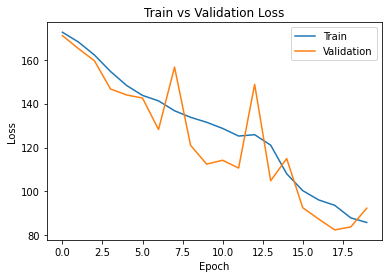

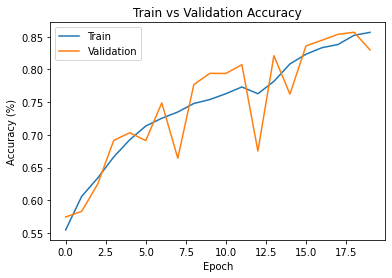

In [ ]:
train(num_epochs, batch_size, learning_rate)

In [ ]:
test_acc = accuracy(test_data)
print("Test accuracy of model gru_rnn: " + str(test_acc*100) + "%")

Test accuracy of model gru_rnn: 83.12%


**Question 12:[1 points]**  Plot the training accuracy and the validation accuracy versus the number of epochs. What is the generalization gap between the test and training?

From the graph posted, the highest training accuracy was 85.66% at epoch 20. The highest validation accuracy is 85.68%.

Upon finding the test accuracy, it is 83.12%.

Thus, the generalization gap is the difference between the training accuracy and test accuracy.

Generalization Gap = Train Accuracy - Test Accuracy = 85.66% - 83.12% = 2.54%.

# Comparing SGD with Adam

**Question 13** [4 points]: Train the same model with the same parameters using the Adam optimizer instead of the SGD. Do not forgot to initialize the network before training, otherwise the previous model will continue training from the final model parameters rather than start from a fresh set of random weight initialization values.

In [ ]:
# Define (again) your model here
gru_rnn2 = objax.nn.Sequential([
    Embed(max_vocab, embedding_size),   
    GRU(embedding_size, num_hidden_units_GRU),
    objax.nn.Linear(num_hidden_units_GRU, num_hidden_units),
    objax.functional.relu,
    objax.nn.Linear(num_hidden_units, 2)
])

In [ ]:
## Your implementaiton of the optimizer should go here
opt2 = objax.optimizer.Adam(gru_rnn2.vars())

You will also need the following functions.

In [ ]:
def loss_function(x: JaxArray, y: JaxArray):
    logits = gru_rnn2(x, initial_state=jn.zeros((x.shape[0], num_hidden_units_GRU)))
    return objax.functional.loss.cross_entropy_logits_sparse(logits, y).sum()


gv2 = objax.GradValues(loss_function, gru_rnn2.vars())


@objax.Function.with_vars(gv2.vars() + opt2.vars())
def train_op(x: JaxArray, y: JaxArray, lr: float):
    g, loss = gv2(x, y)
    opt2(lr, g)
    return loss


train_op = objax.Jit(train_op)
eval_op = objax.Jit(lambda x: gru_rnn2(x, initial_state=jn.zeros((x.shape[0], num_hidden_units_GRU))),
                    gru_rnn2.vars())

In [ ]:
learning_rate = 1e-3
num_epochs = 20
batch_size = 250 
training_data = (messages_train, labels_train)
validation_data = (messages_valid, labels_valid)
test_data = (messages_test, labels_test)


In [ ]:
 # you code for the training loop should start here 
def train2(EPOCHS = 20, BATCH = 32, LEARNING_RATE = 9e-4):
  avg_train_loss_epoch = []
  avg_val_loss_epoch = [] 
  train_acc_epoch = [] 
  val_acc_epoch = []

  for epoch in range(EPOCHS):
      avg_train_loss = 0 # (averaged) training loss per batch
      avg_val_loss =  0  # (averaged) validation loss per batch
      train_acc = 0      # training accuracy per batch
      val_acc = 0        # validation accuracy per batch

      # shuffle the examples prior to training to remove correlation 
      train_indices = np.arange(len(messages_train)) 
      np.random.shuffle(train_indices)
      for it in range(0, messages_train.shape[0], BATCH):
          batch = train_indices[it:it+BATCH] # put code here
          avg_train_loss += float(train_op(messages_train[batch], labels_train[batch], LEARNING_RATE)[0]) * len(batch)
          train_prediction = eval_op(messages_train[batch]).argmax(1)
          train_acc += (np.array(train_prediction).flatten() == labels_train[batch]).sum()
      train_acc_epoch.append(train_acc/messages_train.shape[0])   
      avg_train_loss_epoch.append(avg_train_loss/messages_train.shape[0])

      # run validation
      val_indices = np.arange(len(messages_valid)) 
      np.random.shuffle(val_indices)    
      for it in range(0, messages_valid.shape[0], BATCH):
          batch = val_indices[it:it+BATCH] # put code here
          avg_val_loss += float(loss_function(messages_valid[batch], labels_valid[batch])) * len(batch) 
          val_prediction = eval_op(messages_valid[batch]).argmax(1)
          val_acc += (np.array(val_prediction).flatten() == labels_valid[batch]).sum()
      val_acc_epoch.append(val_acc/messages_valid.shape[0])
      avg_val_loss_epoch.append(avg_val_loss/messages_valid.shape[0])

      print('Epoch %04d  Training Loss %.2f Validation Loss %.2f Training Accuracy %.2f Validation Accuracy %.2f' % (epoch + 1, avg_train_loss/messages_train.shape[0], avg_val_loss/messages_valid.shape[0], 100*train_acc/messages_train.shape[0], 100*val_acc/messages_valid.shape[0]))
  
  #Plot training loss
  plt.title("Train vs Validation Loss")
  plt.plot(avg_train_loss_epoch, label="Train")
  plt.plot(avg_val_loss_epoch, label="Validation")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.legend(loc='best')
  plt.show()

  plt.title("Train vs Validation Accuracy")
  plt.plot(train_acc_epoch, label="Train")
  plt.plot(val_acc_epoch, label="Validation")
  plt.xlabel("Epoch")
  plt.ylabel("Accuracy (%)")
  plt.legend(loc='best')
  plt.show()


Epoch 0001  Training Loss 118.35 Validation Loss 78.51 Training Accuracy 77.62 Validation Accuracy 86.74
Epoch 0002  Training Loss 74.13 Validation Loss 74.57 Training Accuracy 88.39 Validation Accuracy 87.20
Epoch 0003  Training Loss 67.63 Validation Loss 69.69 Training Accuracy 89.51 Validation Accuracy 87.94
Epoch 0004  Training Loss 63.29 Validation Loss 69.34 Training Accuracy 90.30 Validation Accuracy 87.94
Epoch 0005  Training Loss 60.26 Validation Loss 69.54 Training Accuracy 90.79 Validation Accuracy 88.22
Epoch 0006  Training Loss 58.13 Validation Loss 70.03 Training Accuracy 91.23 Validation Accuracy 88.18
Epoch 0007  Training Loss 54.54 Validation Loss 75.62 Training Accuracy 91.77 Validation Accuracy 87.00
Epoch 0008  Training Loss 52.17 Validation Loss 74.81 Training Accuracy 92.17 Validation Accuracy 87.88
Epoch 0009  Training Loss 48.75 Validation Loss 73.86 Training Accuracy 92.87 Validation Accuracy 87.54
Epoch 0010  Training Loss 46.08 Validation Loss 80.10 Training 

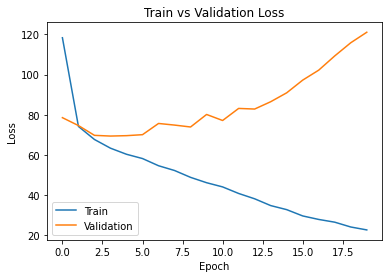

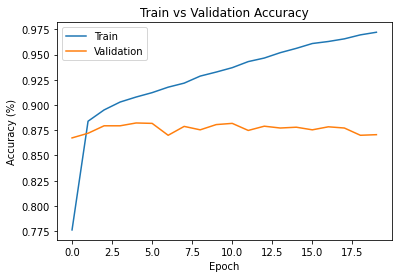

In [ ]:
train2(num_epochs, batch_size, learning_rate)

In [ ]:
test_acc = accuracy(test_data)
print("Test accuracy of model gru_rnn: " + str(test_acc*100) + "%")

Test accuracy of model gru_rnn: 87.520004%


**Question 14** [1 points]: Plot the training accuracy and validation accuracy versus the epochs, and compare your results with the case that you trained the network using SGD. What is the generalization gap for this case?

Comparing SGD and Alex optimizers in this instance, I notice that the training accuracy is higher with the Alex optimizer - it went from 85.66% with SGD to 97.22% with Alex. Furthermore, the test accuracy is also slightly higher - going from 83.12% with SGD to 87.52% with Alex. The validation accuracy for the Adam optimizer is 88.22%.

For the Alex optimizer, the generalization gap is the difference between the training accuracy and test accuracy.

Generalization Gap = Train Accuracy - Test Accuracy = 97.22% - 87.52% = 9.70%.

The generalization gap for the Alex Optimizer is also higher than that for the SGD as the training accuracy is significantly higher. 

**Questions 15** [1 points]: Briefly explain how Adam optimizer works and compare it with the SGD optimizaer.

For all weight updates in SGD, we keep a single learning rate (learning rate/alpha). Throughout training, this learning rate stays constant. From adaptive moment estimation, the Adam optimizer is derived. The key concept is that each network weight or parameter has a separate learning rate that is maintained and adjusted throughout learning and training. The approach computes individual adaptive learning rates for various parameters from estimations of the first and second moments of the gradients.

Adam optimizer combines benefits of two others extensions of SGD - Adaptive Gradient Algorithm and Root Mean Square Propagation. From our GRU models with SGD and Adam respectively, we can see how Adam achieves a higher test accuracy, validation accuracy, and incredibly high training accuracy. It achieves these results quicker and a better rate than SGD. Ultimately, I see Adam optimization as a step up from SGD, even if it requires more hyperparameter tuning and additional calculations at each stage to get the optimum model. This is so that we can minimise the cost function in SGD, which involves numerous noisy steps. So, it moves slower. Our learning rate relies on how quickly our gradient is changing, thus we move more quickly when we are starting out and less quickly when we are getting close to a minimum in Adam's solution employing momentum.

Sources:
https://towardsai.net/p/l/why-should-adam-optimizer-not-be-the-default-learning-algorithm#:~:text=SGD%20produces%20the%20same%20performance,second%20moments%20of%20the%20gradients.

https://medium.com/geekculture/a-2021-guide-to-improving-cnns-optimizers-adam-vs-sgd-495848ac6008



# Early Stopping

**Questions 16** [3 points]: 
This time implement the early stopping method with a patience window. All the parameters are the same as the previous section. Also, set the patience window to 5 epochs.

In [ ]:
# Your implementation of the model should go here
gru_rnn3 = objax.nn.Sequential([
    Embed(max_vocab, embedding_size),   
    GRU(embedding_size, num_hidden_units_GRU),
    objax.nn.Linear(num_hidden_units_GRU, num_hidden_units),
    objax.functional.relu,
    objax.nn.Linear(num_hidden_units, 2)
])

In [ ]:
## Your implementaiton of the optimizer should go here
opt3 = objax.optimizer.Adam(gru_rnn3.vars())

You will also need the following functions.

In [ ]:
def loss_function(x: JaxArray, y: JaxArray):
    logits = gru_rnn3(x, initial_state=jn.zeros((x.shape[0], num_hidden_units_GRU)))
    return objax.functional.loss.cross_entropy_logits_sparse(logits, y).sum()


gv3 = objax.GradValues(loss_function, gru_rnn3.vars())


@objax.Function.with_vars(gv3.vars() + opt3.vars())
def train_op(x: JaxArray, y: JaxArray, lr: float):
    g, loss = gv3(x, y)
    opt3(lr, g)
    return loss


train_op = objax.Jit(train_op)
eval_op = objax.Jit(lambda x: gru_rnn3(x, initial_state=jn.zeros((x.shape[0], num_hidden_units_GRU))),
                    gru_rnn3.vars())

In [ ]:
learning_rate = 1e-3
num_epochs = 20
batch_size = 250 
max_patience_window = 5
training_data = (messages_train, labels_train)
validation_data = (messages_valid, labels_valid)
test_data = (messages_test, labels_test)

In [ ]:
# you code for the training loop should start here 
# you code for the training loop should start here 
def train3(EPOCHS = 20, BATCH = 32, LEARNING_RATE = 9e-4):
  count = 0
  patience = 5
  avg_train_loss_epoch = []
  avg_val_loss_epoch = [] 
  train_acc_epoch = [] 
  val_acc_epoch = []

  for epoch in range(EPOCHS):
      avg_train_loss = 0 # (averaged) training loss per batch
      avg_val_loss =  0  # (averaged) validation loss per batch
      train_acc = 0      # training accuracy per batch
      val_acc = 0        # validation accuracy per batch

      # shuffle the examples prior to training to remove correlation 
      train_indices = np.arange(len(messages_train)) 
      np.random.shuffle(train_indices)
      for it in range(0, messages_train.shape[0], BATCH):
          batch = train_indices[it:it+BATCH] # put code here
          avg_train_loss += float(train_op(messages_train[batch], labels_train[batch], LEARNING_RATE)[0]) * len(batch)
          train_prediction = eval_op(messages_train[batch]).argmax(1)
          train_acc += (np.array(train_prediction).flatten() == labels_train[batch]).sum()
      train_acc_epoch.append(train_acc/messages_train.shape[0])   
      avg_train_loss_epoch.append(avg_train_loss/messages_train.shape[0])

      # run validation
      val_indices = np.arange(len(messages_valid)) 
      np.random.shuffle(val_indices)    
      for it in range(0, messages_valid.shape[0], BATCH):
          batch = val_indices[it:it+BATCH] # put code here
          avg_val_loss += float(loss_function(messages_valid[batch], labels_valid[batch])) * len(batch) 
          val_prediction = eval_op(messages_valid[batch]).argmax(1)
          val_acc += (np.array(val_prediction).flatten() == labels_valid[batch]).sum()
      val_acc_epoch.append(val_acc/messages_valid.shape[0])
      
      if avg_val_loss_epoch and avg_val_loss/messages_valid.shape[0] > avg_val_loss_epoch[-1]:
        count+=1
      else:
        count = 0
      if count == patience:
        break
      avg_val_loss_epoch.append(avg_val_loss/messages_valid.shape[0])

      print('Epoch %04d  Training Loss %.2f Validation Loss %.2f Training Accuracy %.2f Validation Accuracy %.2f Count %d' % (epoch + 1, avg_train_loss/messages_train.shape[0], avg_val_loss/messages_valid.shape[0], 100*train_acc/messages_train.shape[0], 100*val_acc/messages_valid.shape[0], count))
  
  #Plot training loss
  plt.title("Train vs Validation Loss")
  plt.plot(avg_train_loss_epoch, label="Train")
  plt.plot(avg_val_loss_epoch, label="Validation")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.legend(loc='best')
  plt.show()

  plt.title("Train vs Validation Accuracy")
  plt.plot(train_acc_epoch, label="Train")
  plt.plot(val_acc_epoch, label="Validation")
  plt.xlabel("Epoch")
  plt.ylabel("Accuracy (%)")
  plt.legend(loc='best')
  plt.show()

Epoch 0001  Training Loss 117.20 Validation Loss 76.69 Training Accuracy 76.83 Validation Accuracy 86.82 Count 0
Epoch 0002  Training Loss 74.45 Validation Loss 72.39 Training Accuracy 88.36 Validation Accuracy 87.66 Count 0
Epoch 0003  Training Loss 69.27 Validation Loss 70.22 Training Accuracy 89.17 Validation Accuracy 87.94 Count 0
Epoch 0004  Training Loss 66.63 Validation Loss 70.05 Training Accuracy 89.48 Validation Accuracy 88.00 Count 0
Epoch 0005  Training Loss 63.90 Validation Loss 71.99 Training Accuracy 90.01 Validation Accuracy 87.38 Count 1
Epoch 0006  Training Loss 61.38 Validation Loss 68.77 Training Accuracy 90.42 Validation Accuracy 88.30 Count 0
Epoch 0007  Training Loss 57.20 Validation Loss 68.40 Training Accuracy 91.17 Validation Accuracy 88.56 Count 0
Epoch 0008  Training Loss 55.36 Validation Loss 69.33 Training Accuracy 91.50 Validation Accuracy 88.18 Count 1
Epoch 0009  Training Loss 51.99 Validation Loss 69.31 Training Accuracy 92.00 Validation Accuracy 88.46

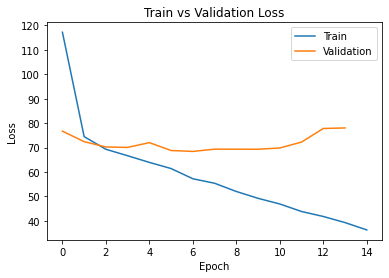

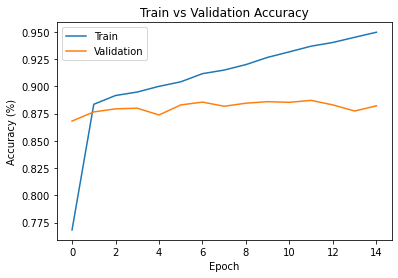

In [ ]:
train3(num_epochs, batch_size, learning_rate)

In [ ]:
test_acc = accuracy(test_data)
print("Test accuracy of model gru_rnn: " + str(test_acc*100) + "%")

Test accuracy of model gru_rnn: 88.420006%


The highest training accuracy is 94.51% and the test accuracy is 88.42%. The highest validation accuracy is 88.72%.

The generalization gap for the early stopping method is the difference between the training accuracy and test accuracy.

Generalization Gap = Train Accuracy - Test Accuracy = 94.51% - 88.42% = 6.09%.

**Question 17**[1 points]: Report the best validation accuracy and the test accuracy of your best model.

The best validation test accuracy I obtained was for my third GRU model, early stopping method; I obtained a validation accuracy of 88.72% and a test accuracy of 88.42%. 